In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data_dir = Path("./captcha_images_v2/")

images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

In [3]:
batch_size = 16
img_width = 200
img_height = 50

In [4]:
downsample_factor = 4

In [5]:
max_length = max([len(label) for label in labels])

Preprocessing

In [6]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters),
                                  mask_token=None)

In [7]:
# Mapping integers back to orignial characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    mask_token=None,
    invert=True
)

In [8]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], \
                       labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], \
                       labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


In [9]:
x_train, x_valid, y_train, y_valid = split_data(np.array(images),
                                                np.array(labels))

In [10]:
# TODO: Figure out how to debug this function.
# TODO: Also figure out how to place this visible in TODO.

def encode_single_sample(img_path, label):

    #1. Read image
    img = tf.io.read_file(img_path)
    #2. Decode and convert it into grayscale
    img = tf.io.decode_png(img, channels=1)
    #3. Convert to float32 in [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    #4. Resize to the desired size.
    img = tf.image.resize(img, [img_height, img_width])
    #5. Transpose the image because we want the time
    #dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1,0,2])
    #6. Map the characters in label to numbers.
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    #7. Return a dict as our model is expecting two inputs.
    return {"image":img, "label": label}

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Visualize the data

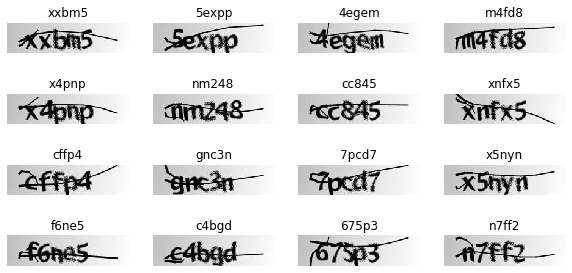

In [12]:
_, ax = plt.subplots(4,4, figsize=(10,5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4 , i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4 , i % 4].set_title(label)
        ax[i // 4 , i % 4].axis("off")
plt.show()

Model

In [13]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):     #(labels, x)
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [14]:
def build_model():
    # Inputs to the model.
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", dtype="float32", shape=(None,)) #None means variable size.

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2,2), name="pool1")(x)

    #Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2,2), name="pool2")(x) # Check out how does MaxPooling reduce size.

    # Accounting for the size mismatch due to downsampling.
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # OutputLayer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Adding CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels],
        outputs=output,
        name="ocr_model_v1"
    )

    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [15]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

Training

In [ ]:
epochs = 100
early_stopping_patience = 10

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=early_stopping_patience,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
